In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
f = open('D:\\Jupyter\\datawhale\\Datawhale_7\\1\\data.csv')
train_data = pd.read_csv(f,index_col=0)
train_data.head()

,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,NaN,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,一线城市,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,0.0,1,xs,1738.0,85.0,蒋红,583.0,79.0,8.0,2.0,6.0,10.0,2018-04-25,2.0,5.0,8.0,552.0,73.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,2018-04-19,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,1.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,一线城市,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0.0,0,xs,779.0,84.0,崔向朝,653.0,73.0,7.0,4.0,2.0,8.0,2018-05-03,2.0,6.0,8.0,635.0,76.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,2018-05-05,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,NaN,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,一线城市,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,0.0,1,xs,338.0,95.0,王中云,654.0,76.0,11.0,5.0,5.0,16.0,2018-05-05,5.0,5.0,14.0,633.0,83.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,2018-05-01,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,NaN,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,三线城市,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0.0,0,xs,1831.0,82.0,何洋洋,595.0,79.0,12.0,7.0,4.0,22.0,2018-05-05,3.0,16.0,17.0,542.0,75.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,2018-05-03,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,NaN,11150,0,12.0,20

In [4]:
len(train_data)

4754

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 5 to 11992
Data columns (total 89 columns):
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
student_featur

In [6]:
#dataset = train_data.fillna(-1)   # 查看行列缺失值
#print((dataset == -1).sum(axis = 0))
#print((dataset == -1).sum(axis = 1))

In [7]:
train_data.isnull().sum().sort_values(ascending = False)

student_feature                               2998
cross_consume_count_last_1_month               426
query_org_count                                304
query_cash_count                               304
latest_six_month_apply                         304
latest_three_month_apply                       304
latest_query_time                              304
query_sum_count                                304
latest_one_month_apply                         304
query_finance_count                            304
apply_credibility                              304
apply_score                                    304
latest_query_day                               304
latest_one_month_loan                          297
loans_score                                    297
loans_credibility_behavior                     297
loans_count                                    297
loans_settle_count                             297
loans_overdue_count                            297
loans_org_count_behavior       

In [8]:
train_data.drop(['student_feature'],axis=1,inplace=True)

In [9]:
for i in range(len(train_data.columns)):
    if (train_data[train_data.columns[i]]).dtype == 'object':
        print(train_data.columns[i])

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [10]:
train_data.drop(['bank_card_no','source','id_name'],axis=1,inplace=True)

In [11]:
print(train_data['reg_preference_for_trad'].unique())
train_data['reg_preference_for_trad'].value_counts()

['一线城市' '三线城市' '境外' '二线城市' '其他城市' nan]


一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [13]:
train_data['reg_preference_for_trad'].fillna(train_data['reg_preference_for_trad'].mode(),inplace=True)
train_data['reg_preference_for_trad'].value_counts()

一线城市    3405
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [14]:
#one-hot
train_data = train_data.join(pd.get_dummies(train_data['reg_preference_for_trad']))
train_data.drop(['reg_preference_for_trad'],axis=1,inplace=True)
train_data.head()

,custid,trade_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,first_transaction_day,trans_day_last_12_month,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外
5,2791858,20180507115231274000000023057383,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,0.0,1,1738.0,85.0,583.0,79.0,8.0,2.0,6.0,10.0,2018-04-25,2.0,5.0,8.0,552.0,73.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,2018-04-19,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,1,0,0,0,0
10,534047,20180507121002192000000023073000,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0.0,0,779.0,84.0,653.0,73.0,7.0,4.0,2.0,8.0,2018-05-03,2.0,6.0,8.0,635.0,76.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,2018-05-05,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,1,0,0,0,0
12,2849787,20180507125159718000000023114911,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,0.0,1,338.0,95.0,654.0,76.0,11.0,5.0,5.0,16.0,2018-05-05,5.0,5.0,14.0,633.0,83.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,2018-05-01,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,1,0,0,0,0
13,1809708,20180507121358683000000388283484,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0.0,0,1831.0,82.0,595.0,79.0,12.0,7.0,4.0,22.0,2018-05-05,3.0,16.0,17.0,542.0,75.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,2018-05-03,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,0,1,0,0,0
14,2499829,20180507115448545000000388205844,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,11150,0,12.0,20170312.0,61470,63.0,0.65,9770,6.0,760,1.00,1110,0.50,0.0,66.0,0.0,66.0,0.0,3.0,3.0,3.0,0.0,1

In [43]:
#train_data['latest_query_time'] = train_data.latest_query_time.astype(str)
#train_data['loans_latest_time'] = train_data.loans_latest_time.astype(str)
train_data['latest_query_time'] = pd.to_datetime(train_data['latest_query_time'],format='%Y-%m-%d %H:%M:%S.%f')
train_data['loans_latest_time'] = pd.to_datetime(train_data['loans_latest_time'],format='%Y-%m-%d %H:%M:%S.%f')

In [48]:
train_data.head()

,custid,low_volume_percent,middle_volume_percent,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,trans_days_interval,regional_mobility,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,status,first_transaction_day,trans_day_last_12_month,apply_score,apply_credibility,query_org_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,loans_score,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外
5,2791858,0.01,0.99,0.90,0.55,0.313,26.0,3.0,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,1,1738.0,85.0,583.0,79.0,8.0,6.0,10.0,373.0,2.0,5.0,552.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,374.0,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,1,0,0,0,0
10,534047,0.02,0.94,1.28,1.00,0.458,14.0,4.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0,779.0,84.0,653.0,73.0,7.0,2.0,8.0,382.0,2.0,6.0,635.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,379.0,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,1,0,0,0,0
12,2849787,0.04,0.96,1.00,1.00,0.114,22.0,1.0,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,1,338.0,95.0,654.0,76.0,11.0,5.0,16.0,408.0,5.0,5.0,633.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,376.0,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,1,0,0,0,0
13,1809708,0.00,0.96,0.13,0.57,0.777,6.0,3.0,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0,1831.0,82.0,595.0,79.0,12.0,4.0,22.0,383.0,3.0,16.0,542.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,379.0,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,0,1,0,0,0
14,2499829,0.01,0.99,0.46,1.00,0.175,42.0,1.0,11150,0,12.0,20170312.0,61470,63.0,0.65,9770,6.0,760,1.00,1110,0.50,0.0,66.0,0.0,66.0,0.0,3.0,3.0,3.0,0.0,1000,3.0,0.0,0,6410,1,435.0,88.0,541.0,75.0,11.0,4.0,14.0,386.0,6.0,8.0,479.0,37.0,32.0,6.0,12.0,2.0,10.0,0.0,0.0,10.0,36.0,25.0,0.0,0.0,360.0,563.0,1800.0,72.0,10.0,10.0,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0,1,0,0,0,0


In [47]:
import datetime
a = (datetime.datetime.today() - train_data['loans_latest_time'])
b = map(lambda a:a.days,a)
train_data['loans_latest_time'] = pd.Series(b)
a = (datetime.datetime.today() - train_data['latest_query_time'])
b = map(lambda a:a.days,a)
train_data['latest_query_time'] = pd.Series(b)

In [30]:
corr = train_data.corr()
corr1 = np.abs(corr['status'])
corr1.sort_values(ascending = False)

status                                     1.000000
trans_fail_top_count_enum_last_1_month     0.332256
history_fail_fee                           0.320033
loans_overdue_count                        0.279125
loans_score                                0.259092
latest_one_month_fail                      0.257269
apply_score                                0.244200
rank_trad_1_month                          0.147258
latest_one_month_suc                       0.138144
trans_fail_top_count_enum_last_6_month     0.133477
trans_fail_top_count_enum_last_12_month    0.117161
top_trans_count_last_1_month               0.117113
consfin_avg_limit                          0.091101
consfin_credit_limit                       0.083844
trans_day_last_12_month                    0.078892
avg_price_top_last_12_valid_month          0.071874
trans_top_time_last_1_month                0.068591
consume_top_time_last_1_month              0.066371
consfin_max_limit                          0.063307
latest_six_m

In [33]:
train_data.drop(['transd_mcc','take_amount_in_later_12_month_highest','loans_credibility_behavior','query_finance_count',
                'latest_six_month_apply','jewelry_consume_count_last_6_month','trans_days_interval_filter','trade_no'],
                axis=1,inplace = True)

In [50]:
train_data.isnull().sum().sort_values(ascending=False)[:20]

latest_query_time                   3008
loans_latest_time                   3004
cross_consume_count_last_1_month     426
query_org_count                      304
apply_score                          304
apply_credibility                    304
query_cash_count                     304
latest_query_day                     304
query_sum_count                      304
latest_one_month_apply               304
latest_three_month_apply             304
loans_cash_count                     297
latest_six_month_loan                297
latest_three_month_loan              297
latest_one_month_loan                297
loans_count                          297
consfin_org_count_behavior           297
loans_org_count_behavior             297
loans_overdue_count                  297
loans_settle_count                   297
dtype: int64

In [51]:
corr1.sort_values(ascending=False)[train_data.isnull().sum().sort_values(ascending= False).keys()[:43]].sort_values(ascending=False)

trans_fail_top_count_enum_last_1_month    0.332256
history_fail_fee                          0.320033
loans_overdue_count                       0.279125
loans_score                               0.259092
latest_one_month_fail                     0.257269
apply_score                               0.244200
latest_one_month_suc                      0.138144
trans_fail_top_count_enum_last_6_month    0.133477
consfin_avg_limit                         0.091101
consfin_credit_limit                      0.083844
avg_price_top_last_12_valid_month         0.071874
consfin_max_limit                         0.063307
latest_six_month_loan                     0.062565
latest_query_day                          0.059274
query_cash_count                          0.054786
latest_three_month_loan                   0.053082
loans_count                               0.048211
consfin_product_count                     0.035339
consfin_org_count_behavior                0.032000
consfin_org_count_current      

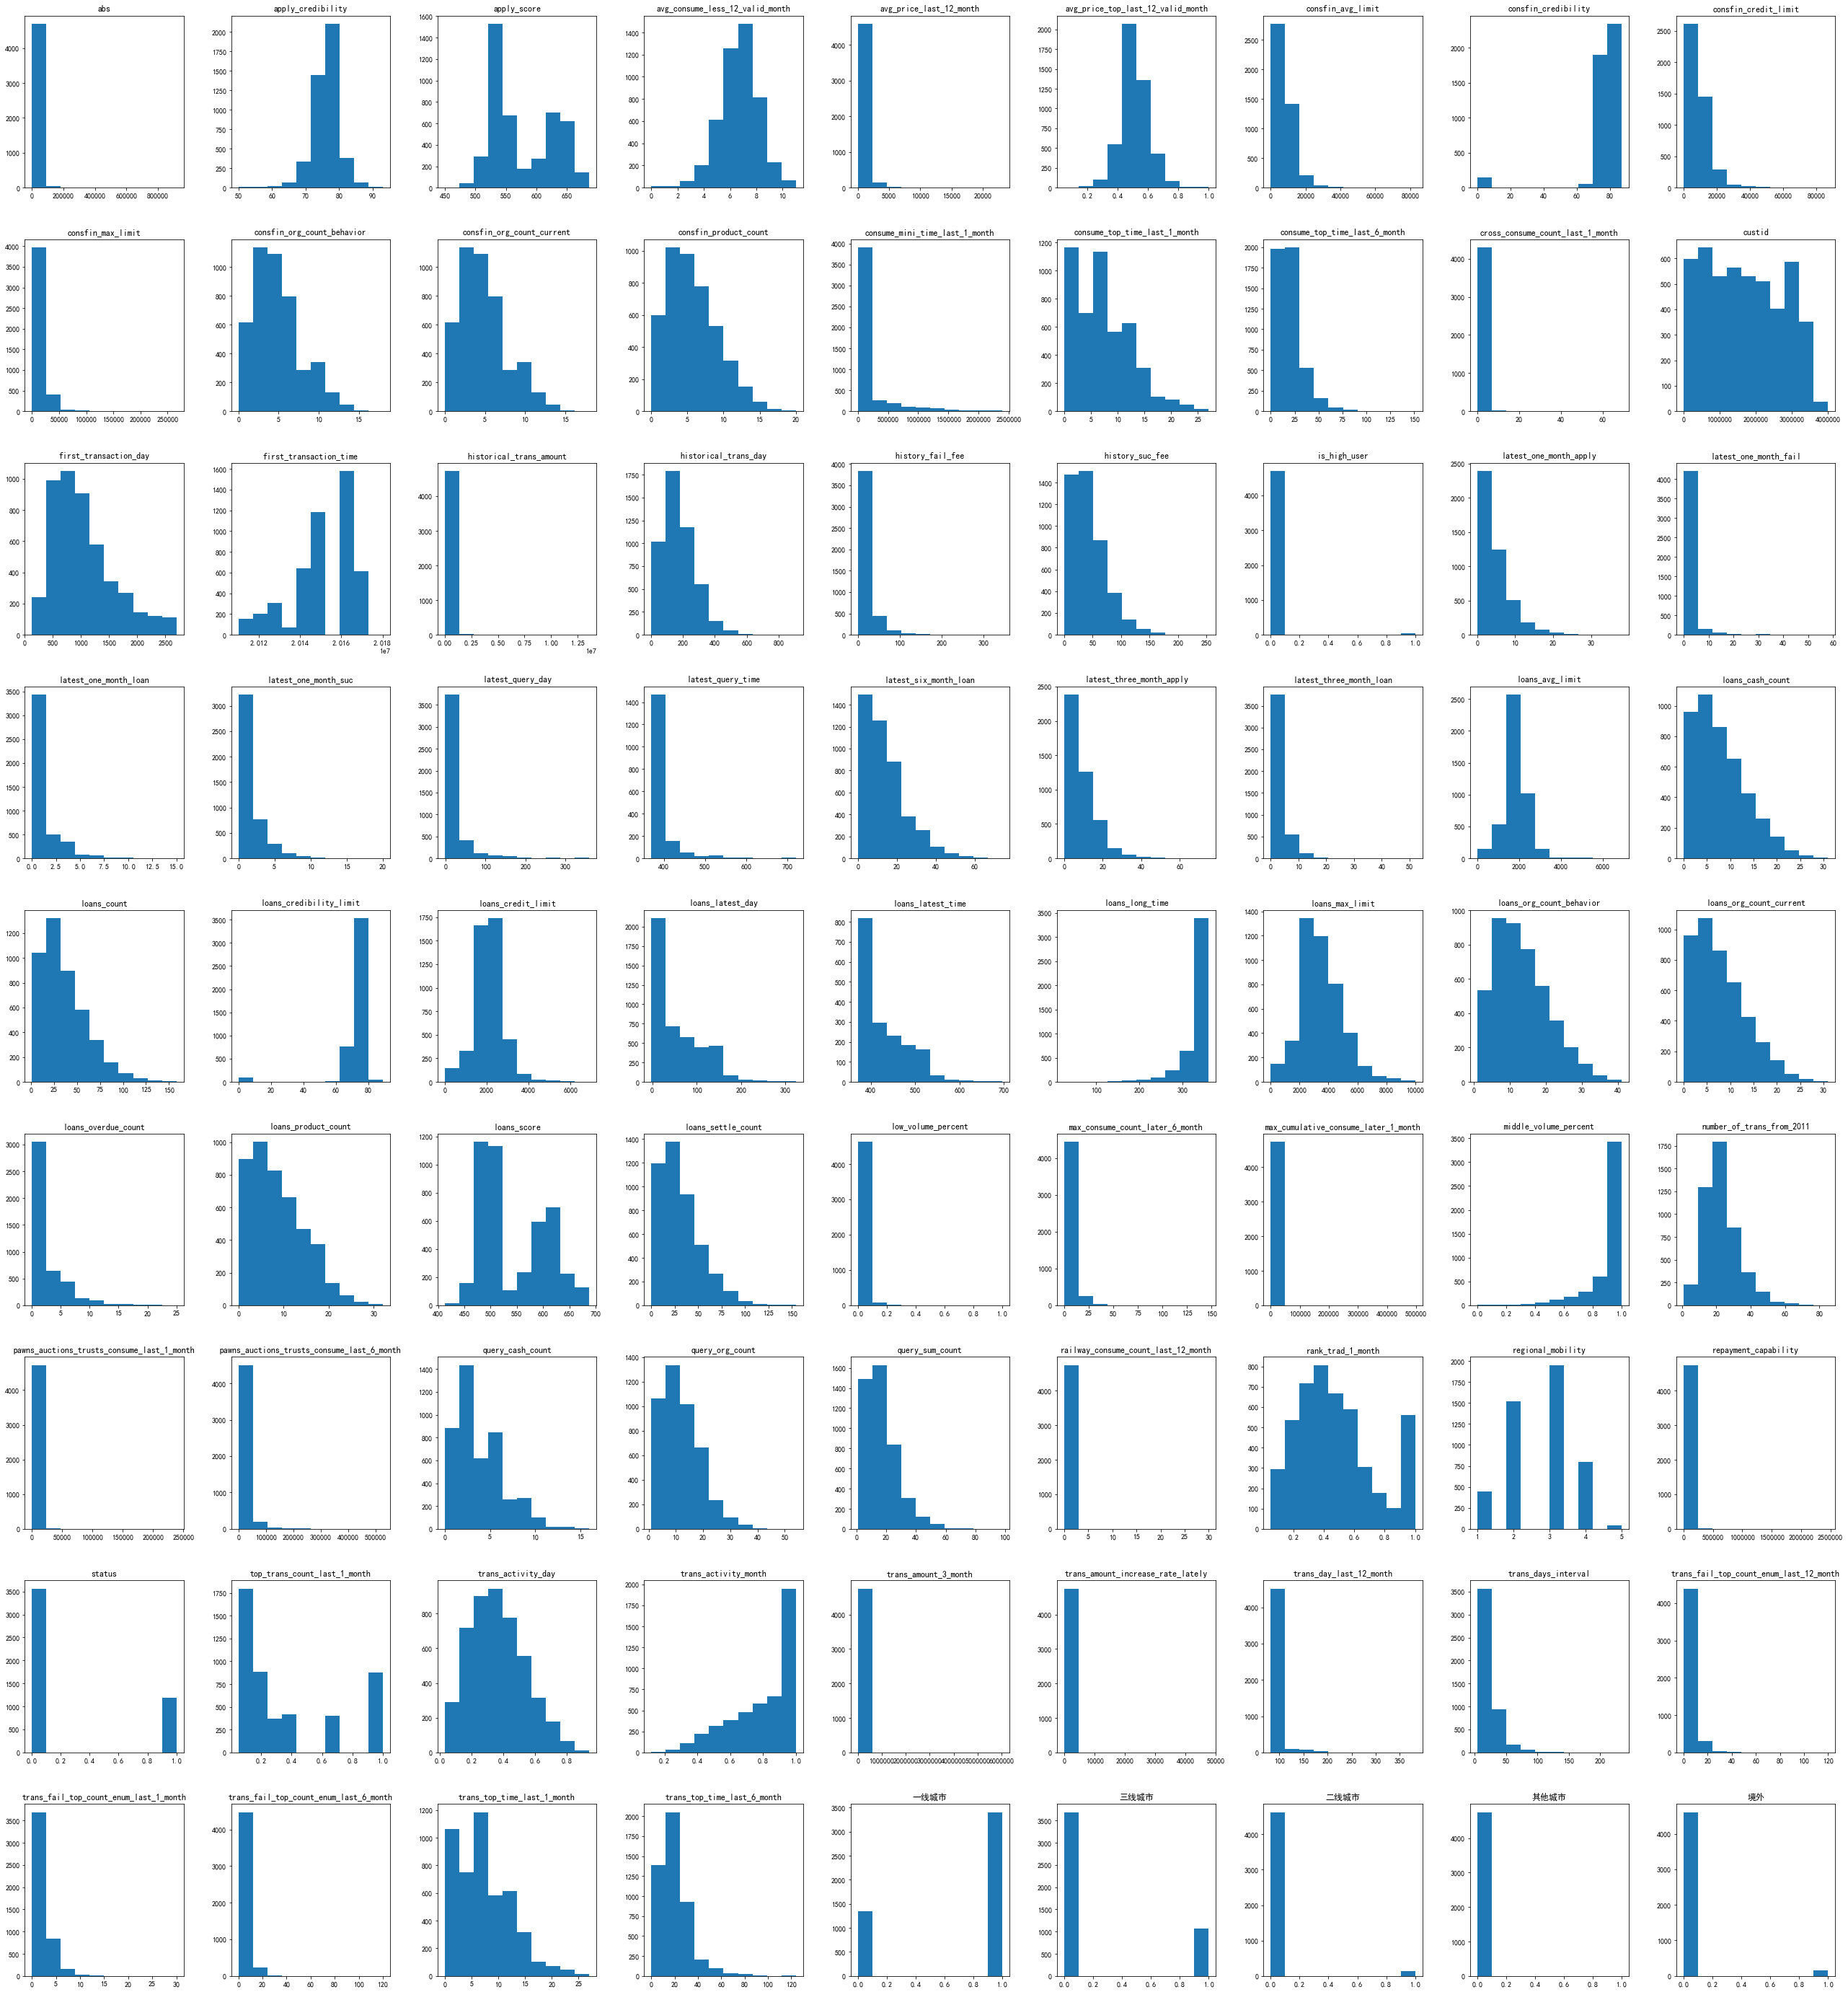

In [52]:
train_data.hist(figsize=(45,50),grid=False)
plt.show()

In [55]:
for i in train_data.keys():
    train_data[i].fillna(train_data[i].median(),inplace=True)
train_data.isnull().sum().sort_values(ascending=False)

境外                                            0
apply_credibility                             0
trans_top_time_last_1_month                   0
trans_top_time_last_6_month                   0
consume_top_time_last_1_month                 0
consume_top_time_last_6_month                 0
cross_consume_count_last_1_month              0
trans_fail_top_count_enum_last_1_month        0
trans_fail_top_count_enum_last_6_month        0
trans_fail_top_count_enum_last_12_month       0
consume_mini_time_last_1_month                0
max_cumulative_consume_later_1_month          0
max_consume_count_later_6_month               0
railway_consume_count_last_12_month           0
pawns_auctions_trusts_consume_last_1_month    0
pawns_auctions_trusts_consume_last_6_month    0
status                                        0
first_transaction_day                         0
trans_day_last_12_month                       0
avg_price_top_last_12_valid_month             0
avg_price_last_12_month                 

In [56]:
y = train_data.status
train_data.drop(['status'],axis=1,inplace=True)
X = train_data

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 2018)